## This is to compare the results from different adjacency criteria.

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import *
from numpy import linalg as LA
import os
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.cluster import KMeans
from sklearn.covariance import MinCovDet, EmpiricalCovariance

from sklearn.metrics.pairwise import *




The new link list contains rook and queen adjacency, but it also contain the special cases of the CT's.
The special cases of the CT's are removed from the data files.
Will first create a dataframe based on the links in the link list, then remove the rows that contain the special cases.

In [3]:
# read the new link list
link_ls = pd.read_csv('./../../Figure/ErieNeighborhood.csv', index_col=0, )
# files to be used
fns = ['Erie2000', 'Erie2010', 'EriePer2000', 'EriePer2010', 'EriePer2010test2']
# read the coordinates of the CT's, for plotting
erie_ctr = pd.read_csv('./../../For Website/Eriecentr.csv', index_col='GEOID10', usecols=['Long', 'Lat', 'GEOID10'])

In [4]:
# initialize a new dataframe for stroing distances of the links
dist_main_ls = link_ls.copy(deep=True)
# fns = ['Erie2000', 'Erie2010', 'EriePer2000', 'EriePer2010', 'EriePer2010test2']
for fn in fns:
    # read file
    dat = pd.read_csv('./'+fn+'.csv', index_col='TRTID10')
    # drop the columns of not numerical information
    dat.drop(axis=1, columns=['YEAR', 'Unnamed: 0'], inplace=True)
    dat[dat.isna()] = 0 # although should not, simpliy set to 0 in case
    dat[dat<0] = 0 # value below 0 is considered to be error code, set to 0 as there is no count.
    dat_m =dat.mean() # get means of columns
    dat_std = dat.std() # get standard deviation of columns
    dat_dm = dat-dat_m # de-mean
    dat_sd= dat_dm/dat_std # scale with standard deviation
    # following lines are estimation of covariance matrix for mahalonibas distance
    minDt_ = MinCovDet(random_state=1).fit(dat_dm.values)
    minD_cov = minDt_.covariance_
    minD_cov_inv = np.linalg.inv(minD_cov)
    
    # initialize columns in the dataframe for stroing the distance values
    dist_main_ls[fn+'_eucli'] = None
    dist_main_ls[fn+'_pca'] = None
    dist_main_ls[fn+'_cos'] = None
    dist_main_ls[fn+'_maha'] = None
    
    # Euclidean distance, in a square distance matrix
    dist_mat_eucli = pd.DataFrame(data=squareform(pdist(dat_sd.values)), index=dat_sd.index, columns=dat_sd.index)
    
    # PCA, to reduce dimension and then calculate Euclidean distance.
    pca = PCA(n_components=8)
    pca.fit(dat_sd.values)
    low_d = pca.fit_transform(dat_dm.values)
    print(f'PCA exp. var. Year {fn}: {pca.explained_variance_ratio_}')
    dist_mat_pca = pd.DataFrame(data=squareform(pdist(low_d[:, :2])), index=dat_sd.index, columns=dat_sd.index)
    
    # Cosine similarity
    cos_simi = cosine_similarity(dat_dm.values)
    cos_simi = pd.DataFrame(data=cos_simi, index=dat_sd.index, columns=dat_sd.index)
    
    
    for idx, row in dist_main_ls.iterrows():

        try:
            dist_main_ls.at[idx,fn+'_eucli'] = dist_mat_eucli[row['V1']][row['V2']]
            dist_main_ls.at[idx,fn+'_cos'] = cos_simi[row['V1']][row['V2']]
            dist_main_ls.at[idx,fn+'_pca'] = dist_mat_pca[row['V1']][row['V2']]
            dist_main_ls.at[idx,fn+'_maha'] =\
            mahalanobis(dat_dm.loc[row['V1']], dat_dm.loc[row['V2']], minD_cov_inv)
    #             np.exp((-1.0/2.0)*(dat_dm.loc[row['V1']])\
    #                    .dot(Sgm_inv).dot(dat_dm.loc[row['V1']]))
        except:
            pass

PCA exp. var. Year Erie2000: [9.51847247e-01 4.37897222e-02 1.77660724e-03 1.67771215e-03
 6.29790078e-04 9.98658532e-05 7.50290959e-05 3.63239834e-05]
PCA exp. var. Year Erie2010: [9.52125755e-01 4.62934739e-02 6.51224479e-04 5.96596544e-04
 2.03003618e-04 4.89186625e-05 2.83786145e-05 1.53761978e-05]
PCA exp. var. Year EriePer2000: [9.54518185e-01 4.37275660e-02 1.52142937e-03 2.24937211e-04
 7.04620078e-06 6.65431310e-07 6.52011597e-08 3.30247637e-08]
PCA exp. var. Year EriePer2010: [9.53216509e-01 4.61478325e-02 5.39206262e-04 9.08093821e-05
 5.28662160e-06 2.67866734e-07 3.70725482e-08 1.36936574e-08]
PCA exp. var. Year EriePer2010test2: [9.53146611e-01 4.61701044e-02 6.69500594e-04 8.11553799e-06
 5.29683731e-06 2.58810055e-07 4.70437380e-08 1.96018022e-08]


In [6]:
dist_main_ls.to_csv('./ErieDiff0010rook_queen_test.csv')

In [5]:
# after calculating the similarity/distance, we can decide which rows have the special cases, and drop them.
nod_set = set(list(dist_main_ls.dropna()['V1'].values.astype(int))\
              +list(dist_main_ls.dropna()['V2'].values.astype(int)))
nod_ls = list(nod_set)

In [6]:
# dictionary for storing all of the adjacency matrix
reslt_dictA = {}
main_result_all = []
# different files
for sel_ppt in fns:
    # different distance types
    for dis_type in ['eucli', 'cos', 'pca', 'maha']:
        # queen or rook adjacency
        for adj_type in ['queen0', 'queen0and1']:
            print(f'Current working: file: {sel_ppt}, distance: {dis_type}, adj: {adj_type}')
            
            # drop the none values of the special case CT's
            dist_main_ls = dist_main_ls.dropna()
            # if queen is 0 only, drop the rows of queen=1
            if adj_type == 'queen0':
#                 dist_main_ls = dist_main_ls[dist_main_ls['Queen']==0]
                dist_main_ls_curr = dist_main_ls[dist_main_ls['Queen']==0]
            else:
                dist_main_ls_curr = dist_main_ls
            
            # dic to store temporary eigen-decomp results
            reslt_dict = {}
            
            # Adjacency/Weight Matrix
            A_mat = np.zeros([len(nod_set), len(nod_set)])

            # the standard deviation of the the edges
#             simi_std = dist_main_ls[sel_ppt+'_'+dis_type].dropna().std()
            simi_std = dist_main_ls_curr[sel_ppt+'_'+dis_type].dropna().std()
            # iterate all of the edges in the list
            for idx, rr in dist_main_ls_curr.iterrows():
                try: # The edge list contains duplicates, and NaN, so use "try" to filter the NaN ones.
                    # the current edge, a tuple
                    crt_edg = (nod_ls.index(int(rr[['V1', 'V2']][0])), nod_ls.index(int(rr[['V1', 'V2']][1])))
                    # assign edge weights based on distance measures,
                    # although all types here are treated same, we still separate the cases,
                    # because it will be easier for future if modifaiction of one type of distance measures
                    # is needed.
                    if dis_type == 'eucli': # Euclidean
                        A_mat[crt_edg[0], crt_edg[1]] =\
                        np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
                    elif dis_type == 'cos': # Cosine similarity
                        # Cosine similarity can be inverted and directly assign to edge weights,
                        # bu here we use the same as other distance types.
                        A_mat[crt_edg[0], crt_edg[1]] =\
                        np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
                    elif dis_type == 'pca': # PCA reduced
                        A_mat[crt_edg[0], crt_edg[1]] =\
                        np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
                    elif dis_type == 'maha':
                        A_mat[crt_edg[0], crt_edg[1]] =\
                        np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
                    # make the matrix symmetric
                    A_mat[crt_edg[1], crt_edg[0]] = A_mat[crt_edg[0], crt_edg[1]]
                except ValueError:
                    pass

            # Eigen-decomposition for Katz centrality
            eig_valA, eig_vecA = np.linalg.eig(A_mat)
            alpha = 1.0/np.max(eig_valA) - 0.0001
            Katz = np.sum(np.linalg.inv(np.diag(np.ones(len(nod_ls))) - alpha*A_mat), axis=1)
            # Laplacian
            D_mat = np.diag(np.sum(A_mat, axis=1)) # Degree matrix
            L_mat = D_mat - A_mat # Laplacian matrix
            eig_val, eig_vec = np.linalg.eig(L_mat) # eigen-decomposition
            eig_vec = eig_vec[:, np.argsort(eig_val)]
            eig_val = eig_val[np.argsort(eig_val)] # sorting based on eigenvalues
            reslt_dict[sel_ppt] = {'eig_val':eig_val, 'eig_vec':eig_vec}
            reslt_dictA[sel_ppt+dis_type+dis_type+adj_type] = A_mat
            
            # different number of clusters
            for n_clst in [10, 12, 15]:
                # intialize kmeans
                kms = KMeans(n_clusters=n_clst)
                kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,1:n_clst])
                
                # append result to main_result_all
                # based on the pd.Multiindex from product, Katz will be duplicated here
                main_result_all.append(kms.labels_)
                main_result_all.append(Katz)

Current working: file: Erie2000, distance: eucli, adj: queen0
Current working: file: Erie2000, distance: eucli, adj: queen0and1
Current working: file: Erie2000, distance: cos, adj: queen0
Current working: file: Erie2000, distance: cos, adj: queen0and1
Current working: file: Erie2000, distance: pca, adj: queen0
Current working: file: Erie2000, distance: pca, adj: queen0and1
Current working: file: Erie2000, distance: maha, adj: queen0
Current working: file: Erie2000, distance: maha, adj: queen0and1
Current working: file: Erie2010, distance: eucli, adj: queen0
Current working: file: Erie2010, distance: eucli, adj: queen0and1
Current working: file: Erie2010, distance: cos, adj: queen0
Current working: file: Erie2010, distance: cos, adj: queen0and1
Current working: file: Erie2010, distance: pca, adj: queen0
Current working: file: Erie2010, distance: pca, adj: queen0and1
Current working: file: Erie2010, distance: maha, adj: queen0
Current working: file: Erie2010, distance: maha, adj: queen0a

In [7]:
# multi index
mu_ind = pd.MultiIndex.from_product([fns, ['eucli', 'cos', 'pca', 'maha'], ['queen0', 'queen0and1'],
                            ['N_cls'+str(x) for x in [10, 12, 15]], ['ClusterID', 'Katz']])
# dataframe for the final results
main_result_allpd = pd.DataFrame(data=np.array(main_result_all).T,columns=mu_ind, index=nod_ls)

In [8]:
main_result_allpd.to_excel('./rook_vs_queen_all_corrected.xlsx')

In [14]:
import pickle
with open ('./adj_mat_all.pkl', 'wb') as fp:
    pickle.dump(reslt_dictA, fp)

## The above created graph based on the adjacency of the CTs, below we will create a fully connected graph, i.e., there is an edge between every pair of the CT's. The weights of the edges will be determined by socio-space and geo-space.
## We will start with maha distance as the measure in socio-space.

# Below are old code, but with plotting figures
# Except figures, everything have been combined in the above code

## Queen = 0 and 1

In [12]:
dist_main_ls = dist_main_ls.dropna()
reslt_dict = {}
for sel_ppt in ['Erie2000', 'Erie2010', 'EriePer2000', 'EriePer2010', 'EriePer2010test2']:
# for sel_ppt in fns[-1:]:
    A_mat = np.zeros([len(nod_set), len(nod_set)])
    simi_std = dist_main_ls[sel_ppt+'_maha'].dropna().std()
    for idx, rr in dist_main_ls.iterrows():
#         if rr['Queen'] == 0:
            try: # The edge list contains duplicates, and NaN, so use "try" to filter the NaN ones.
                crt_edg = (nod_ls.index(int(rr[['V1', 'V2']][0])), nod_ls.index(int(rr[['V1', 'V2']][1])))
#                 A_mat[crt_edg[0], crt_edg[1]] =\
#                                         np.exp((-1.0/2.0)*rr[sel_ppt+'_maha'])
#                 A_mat[crt_edg[0], crt_edg[1]] = np.exp((-1.0/simi_std)*rr[sel_ppt+'_maha'])
                A_mat[crt_edg[0], crt_edg[1]] = np.exp((-1.0/(2*simi_std**2))*rr[sel_ppt+'_maha']**2)
#                 A_mat[crt_edg[0], crt_edg[1]] = np.exp((-1.0/25)*rr[sel_ppt+'_maha'])
#                 A_mat[crt_edg[0], crt_edg[1]] = rr[sel_ppt+'_maha']
                A_mat[crt_edg[1], crt_edg[0]] = A_mat[crt_edg[0], crt_edg[1]] #rr[sel_ppt]
            except ValueError:
                pass
    D_mat = np.diag(np.sum(A_mat, axis=1)) # Degree matrix
    L_mat = D_mat - A_mat # Laplacian matrix
    eig_val, eig_vec = np.linalg.eig(L_mat) # eigen-decomposition
    eig_vec = eig_vec[:, np.argsort(eig_val)]
    eig_val = eig_val[np.argsort(eig_val)] # sorting based on eigenvalues
    reslt_dict[sel_ppt] = {'eig_val':eig_val, 'eig_vec':eig_vec}

Text(0.5, 0.98, 'Queen = 0 and 1, Edge = $e^{-\\frac{||{x_{maha}-y_{maha}}||^2}{2\\sigma_{maha}^2}}$')

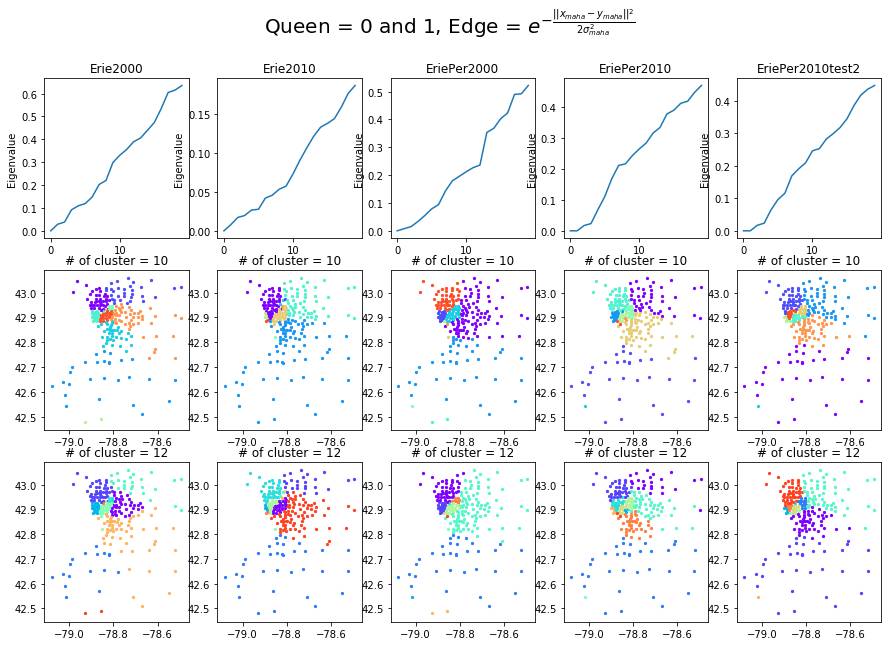

In [14]:
fig4 = plt.figure(figsize=(15,10))
subplt_cnt = 1
n_clst = [10, 10, 10, 10, 10]
# n_clst = [15, 15, 15, 15]
# n_clst = [4, 3, 5, 6]
# n_clst2 = [15, 15, 15, 15, 15]
n_clst2 = [12]*5
kms_lb_ls_maha = []
for sel_ppt in ['Erie2000', 'Erie2010', 'EriePer2000', 'EriePer2010', 'EriePer2010test2']:
#     sel_ppt = sel_ppt+'_maha'
    ax41 = fig4.add_subplot(3,5,subplt_cnt)
    ax42 = fig4.add_subplot(3,5,5+subplt_cnt)
    ax43 = fig4.add_subplot(3,5,10+subplt_cnt)
    ax41.plot(np.abs(reslt_dict[sel_ppt]['eig_val'][:20]))
#     ax12.plot(np.abs(reslt_dict[sel_ppt]['eig_val']))
    ax41.set_title(sel_ppt)
    
    ax41.set_ylabel('Eigenvalue')
    ax42.set_title(f'# of cluster = {n_clst[subplt_cnt-1]}')
    ax43.set_title(f'# of cluster = {n_clst2[subplt_cnt-1]}')
    
    ##############################################
    ##############################################
    # n_clst = [10, 10, 10, 10]
    kms = KMeans(n_clusters=n_clst[subplt_cnt-1])
    kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,1:n_clst[subplt_cnt-1]])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:, n_clst[subplt_cnt-1]:])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,0:10])
    kms_lb_ls_maha.append(kms.labels_)
    for ctid, cllb in zip(nod_ls, kms.labels_):
        ax42.scatter(x=erie_ctr.loc[ctid][0], y=erie_ctr.loc[ctid][1], 
                     c=[cm.rainbow(float(cllb)/float(n_clst[subplt_cnt-1]))],
                    s=5)
    ##############################################
    ##############################################
    # n_clst2 = [5, 5, 5, 5]
    kms = KMeans(n_clusters=n_clst2[subplt_cnt-1])
    kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,1:n_clst2[subplt_cnt-1]])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,:n_clst2[subplt_cnt-1]])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,0:10])
    kms_lb_ls_maha.append(kms.labels_)
    for ctid, cllb in zip(nod_ls, kms.labels_):
        ax43.scatter(x=erie_ctr.loc[ctid][0], y=erie_ctr.loc[ctid][1], 
                     c=[cm.rainbow(float(cllb)/float(n_clst2[subplt_cnt-1]))],
                    s=5)
    subplt_cnt+=1
fig4.suptitle(r'Queen = 0 and 1, Edge = $e^{-\frac{||{x_{maha}-y_{maha}}||^2}{2\sigma_{maha}^2}}$', fontsize=20)
# fig4.savefig('correctEriePer10_queen01', dpi=250, bbox_inches='tight')

## Queen = 0 only

In [26]:
#dist_main_ls = dist_main_ls.dropna() 

dist_main_ls = dist_main_ls[dist_main_ls['Queen']==0]# == Non
reslt_dict = {}
for sel_ppt in ['Erie2000', 'Erie2010', 'EriePer2000', 'EriePer2010', 'EriePer2010test2']:
# for sel_ppt in fns[-1:]:
    A_mat = np.zeros([len(nod_set), len(nod_set)])
    simi_std = dist_main_ls[sel_ppt+'_maha'].dropna().std()
    for idx, rr in dist_main_ls.iterrows():
#         if rr['Queen'] == 0:
            try: # The edge list contains duplicates, and NaN, so use "try" to filter the NaN ones.
                crt_edg = (nod_ls.index(int(rr[['V1', 'V2']][0])), nod_ls.index(int(rr[['V1', 'V2']][1])))
#                 A_mat[crt_edg[0], crt_edg[1]] =\
#                                         np.exp((-1.0/2.0)*rr[sel_ppt+'_maha'])
#                 A_mat[crt_edg[0], crt_edg[1]] = np.exp((-1.0/simi_std)*rr[sel_ppt+'_maha'])
                A_mat[crt_edg[0], crt_edg[1]] = np.exp((-1.0/(2*simi_std**2))*rr[sel_ppt+'_maha']**2)
#                 A_mat[crt_edg[0], crt_edg[1]] = np.exp((-1.0/25)*rr[sel_ppt+'_maha'])
#                 A_mat[crt_edg[0], crt_edg[1]] = rr[sel_ppt+'_maha']
                A_mat[crt_edg[1], crt_edg[0]] = A_mat[crt_edg[0], crt_edg[1]] #rr[sel_ppt]
            except ValueError:
                pass
    D_mat = np.diag(np.sum(A_mat, axis=1)) # Degree matrix
    L_mat = D_mat - A_mat # Laplacian matrix
    eig_val, eig_vec = np.linalg.eig(L_mat) # eigen-decomposition
    eig_vec = eig_vec[:, np.argsort(eig_val)]
    eig_val = eig_val[np.argsort(eig_val)] # sorting based on eigenvalues
    reslt_dict[sel_ppt] = {'eig_val':eig_val, 'eig_vec':eig_vec}

Text(0.5, 0.98, 'Queen = 0 only, Edge = $e^{-\\frac{||{x_{maha}-y_{maha}}||^2}{2\\sigma_{maha}^2}}$')

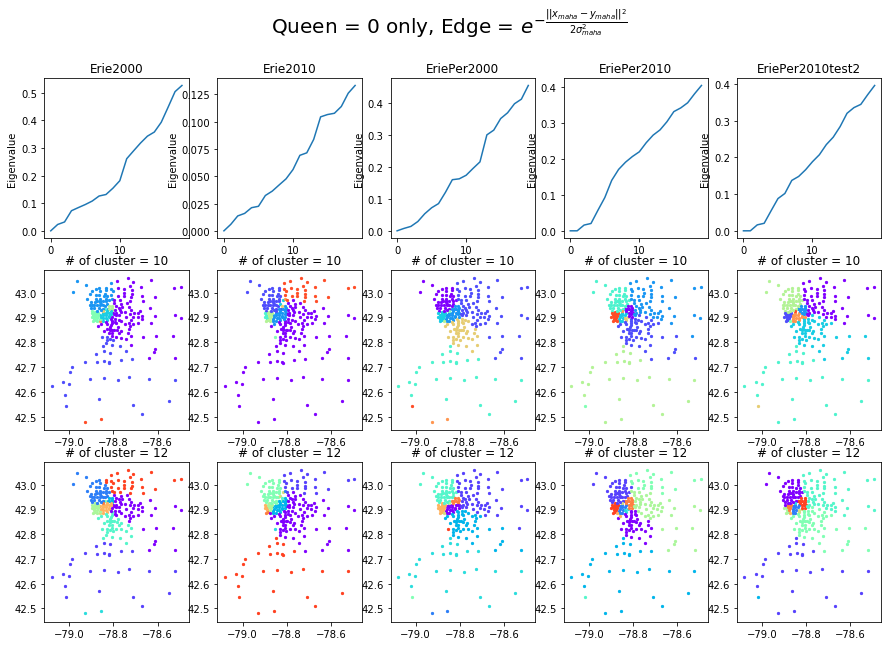

In [28]:
fig4 = plt.figure(figsize=(15,10))
subplt_cnt = 1
n_clst = [10, 10, 10, 10, 10]
# n_clst = [15, 15, 15, 15]
# n_clst = [4, 3, 5, 6]
# n_clst2 = [15, 15, 15, 15, 15]
n_clst2 = [12]*5
kms_lb_ls_maha = []
for sel_ppt in ['Erie2000', 'Erie2010', 'EriePer2000', 'EriePer2010', 'EriePer2010test2']:
#     sel_ppt = sel_ppt+'_maha'
    ax41 = fig4.add_subplot(3,5,subplt_cnt)
    ax42 = fig4.add_subplot(3,5,5+subplt_cnt)
    ax43 = fig4.add_subplot(3,5,10+subplt_cnt)
    ax41.plot(np.abs(reslt_dict[sel_ppt]['eig_val'][:20]))
#     ax12.plot(np.abs(reslt_dict[sel_ppt]['eig_val']))
    ax41.set_title(sel_ppt)
    
    ax41.set_ylabel('Eigenvalue')
    ax42.set_title(f'# of cluster = {n_clst[subplt_cnt-1]}')
    ax43.set_title(f'# of cluster = {n_clst2[subplt_cnt-1]}')
    
    ##############################################
    ##############################################
    # n_clst = [10, 10, 10, 10]
    kms = KMeans(n_clusters=n_clst[subplt_cnt-1])
    kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,1:n_clst[subplt_cnt-1]])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:, n_clst[subplt_cnt-1]:])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,0:10])
    kms_lb_ls_maha.append(kms.labels_)
    for ctid, cllb in zip(nod_ls, kms.labels_):
        ax42.scatter(x=erie_ctr.loc[ctid][0], y=erie_ctr.loc[ctid][1], 
                     c=[cm.rainbow(float(cllb)/float(n_clst[subplt_cnt-1]))],
                    s=5)
    ##############################################
    ##############################################
    # n_clst2 = [5, 5, 5, 5]
    kms = KMeans(n_clusters=n_clst2[subplt_cnt-1])
    kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,1:n_clst2[subplt_cnt-1]])
#     kms.fit(reslt_dict[sel_ppt]['eig_vec'][:,0:10])
    kms_lb_ls_maha.append(kms.labels_)
    for ctid, cllb in zip(nod_ls, kms.labels_):
        ax43.scatter(x=erie_ctr.loc[ctid][0], y=erie_ctr.loc[ctid][1], 
                     c=[cm.rainbow(float(cllb)/float(n_clst2[subplt_cnt-1]))],
                    s=5)
    subplt_cnt+=1
fig4.suptitle(r'Queen = 0 only, Edge = $e^{-\frac{||{x_{maha}-y_{maha}}||^2}{2\sigma_{maha}^2}}$', fontsize=20)
# fig4.savefig('correctEriePer10_queen0only', dpi=250, bbox_inches='tight')

In [30]:
dist_main_ls.dropna()
# low_d[:, :2]

V1           V2  Queen Erie2000_eucli Erie2000_pca  \
OBJECTID                                                                
1         36029000110  36029000200      0        2.90807      3601.08   
2         36029000110  36029000500      0        1.20569        20068   
3         36029000110  36029000600      0        4.00043      12698.4   
4         36029000110  36029000800      0        5.06095      16014.7   
5         36029000110  36029012300      0        1.84001      8716.94   
6         36029000110  36029012501      0        4.67167      25158.4   
7         36029000110  36029016200      0        1.67244      19738.2   
8         36029000110  36029016300      0        1.55662      25067.5   
9         36029000110  36029017400      0        4.95794      20534.5   
11        36029000200  36029000110      0        2.90807      3601.08   
12        36029000200  36029000800      0        2.82411      16472.2   
13        36029000200  36029000900      0        3.18053      15473.8   
14        36029000200  36029001100      0        1.80941      5788.71   
15        36029000200  36029016300      0         2.7985      25395.3   
16        36029000500  36029000110      0        1.20569        20068   
17        36029000500  36029007202      0        4.64979       126817   
18        36029000500  36029016300      0        1.25608      5107.41   
19        36029000500  36029016400      0        5.13866       5984.5   
20        36029000500  36029016500      0        3.39263      40918.8   
22        36029000600  36029000110      0        4.00043      12698.4   
23        36029000600  36029000700      0        1.99855      11471.3   
24        36029000600  36029000800      0        1.83995      3440.14   
25        36029000600  36029012501      0        3.22996      13663.2   
26        36029000700  36029000600      0        1.99855      11471.3   
27        36029000700  36029000800      0        2.76556      8283.51   
28        36029000700  36029001000      0        4.05833      20003.8   
29        36029000700  36029012001      0        2.23075      7504.68   
30        36029000700  36029012501      0        3.81617      8041.78   
31        36029000800  36029000110      0        5.06095      16014.7   
32        36029000800  36029000200      0        2.82411      16472.2   
...               ...          ...    ...            ...          ...   
1348      36029017100  36029005500      0        4.02621      3841.09   
1349      36029017100  36029005900      0        6.08478      4550.85   
1350      36029017100  36029006100      0         3.8877      3080.42   
1352      36029017100  36029006301      0        6.56898      37026.9   
1353      36029017100  36029006302      0        9.94755       147537   
1354      36029017200  36029007600      0        1.92897      18635.5   
1355      36029017200  36029007700      0        4.29497       6244.8   
1356      36029017200  36029007901      0        3.44343      42394.8   
1357      36029017300  36029011200      0        2.67088      8146.96   
1358      36029017300  36029011700      0        5.61217        26341   
1359      36029017300  36029011800      0        5.78993      19418.4   
1360      36029017300  36029012002      0        6.82394      9387.42   
1361      36029017300  36029012003      0        4.74138      3915.01   
1362      36029017300  36029013702      0        5.14967      32246.8   
1363      36029017300  36029014102      0        3.77077      25608.7   
1364      36029017400  36029000110      0        4.95794      20534.5   
1365      36029017400  36029012300      0        4.81238      25902.4   
1366      36029017400  36029012400      0        5.09083      16803.3   
1367      36029017400  36029012800      0        5.79817        39521   
1368      36029017400  36029013001      0        5.61285      42112.9   
1371      36029017501  36029017502      0       0.952406      7106.53   
1372      36029017501  36029940000      0        2.33572      17887.5   
1373